**GRASP-AND-LIFT EEG Detection Project**

This project aims to compare different machine learning models in terms of viability for detecting events from EEG signals.

In [291]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mne
from typing import Literal

In [292]:
SAMPLING_FREQUENCY = 500

def loadSubjectSeries(subject: int, series: int, what : Literal["train", "test"]) -> mne.io.RawArray:
    pandata = pd.read_csv(f"data/{what}/subj{subject}_series{series}_data.csv")
    pandata = pandata.drop(["id"],axis=1)
    channel_names = list(pandata.keys())
    info = mne.create_info(ch_names = channel_names, ch_types=["eeg" for _ in range(len(channel_names))] ,sfreq=SAMPLING_FREQUENCY)

    data = mne.io.RawArray(pandata.transpose().to_numpy(), info)
    data.set_montage('easycap-M1')
    return data, channel_names


def icaTransform(data: mne.io.RawArray) -> mne.preprocessing.ICA:
    ica = mne.preprocessing.ICA(random_state=42)
    ica.fit(data)
    return ica

def searchIcaTemplates(modelIca, templateIndices, sampleIca):
    componentsToRemove = []
    for template in templateIndices:
        _, labels = mne.preprocessing.corrmap([modelIca, sampleIca], template=(0, template), plot=False)
        componentsToRemove.append(labels)
    return componentsToRemove

def applyIca(ica: mne.preprocessing.ICA, componentsToRemove, data: mne.io.RawArray) -> mne.io.RawArray:
    ica.exclude = componentsToRemove
    return ica.apply(data)

def bandFilter(data: mne.io.RawArray) -> mne.io.RawArray:
    return data.filter(13,50)



In [293]:
data, keys = loadSubjectSeries(1,1, "train")
data = bandFilter(data)
modelIca = icaTransform(data)

Creating RawArray with float64 data, n_channels=32, n_times=119496
    Range : 0 ... 119495 =      0.000 ...   238.990 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 509 samples (1.018 sec)

Fitting ICA to data using 32 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.1s finished


Selecting by non-zero PCA components: 32 components
Fitting ICA took 3.4s.


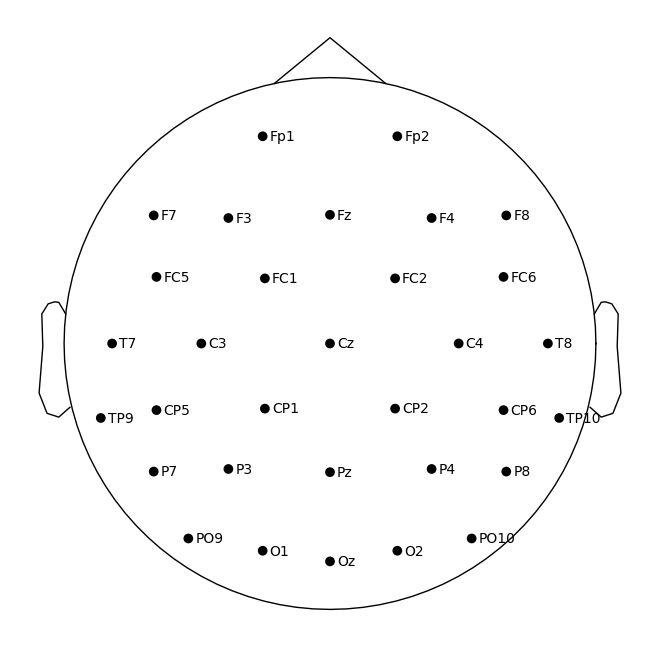

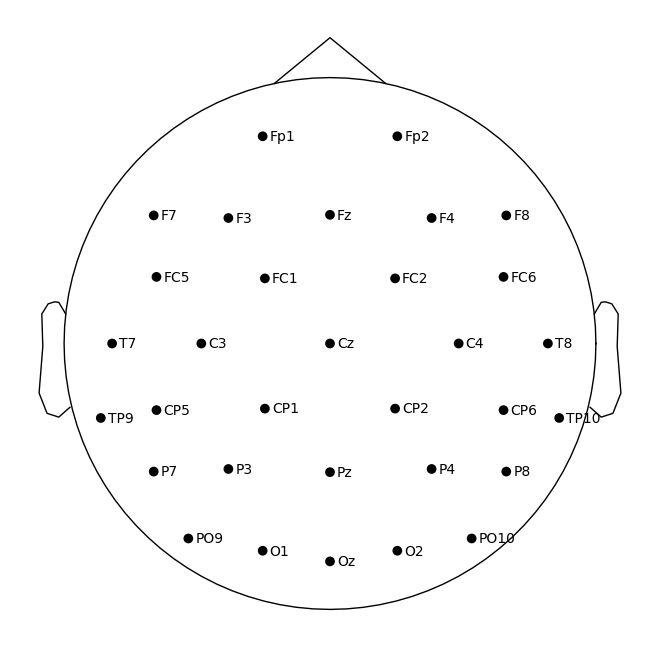

In [294]:
data.plot_sensors(show_names = True)

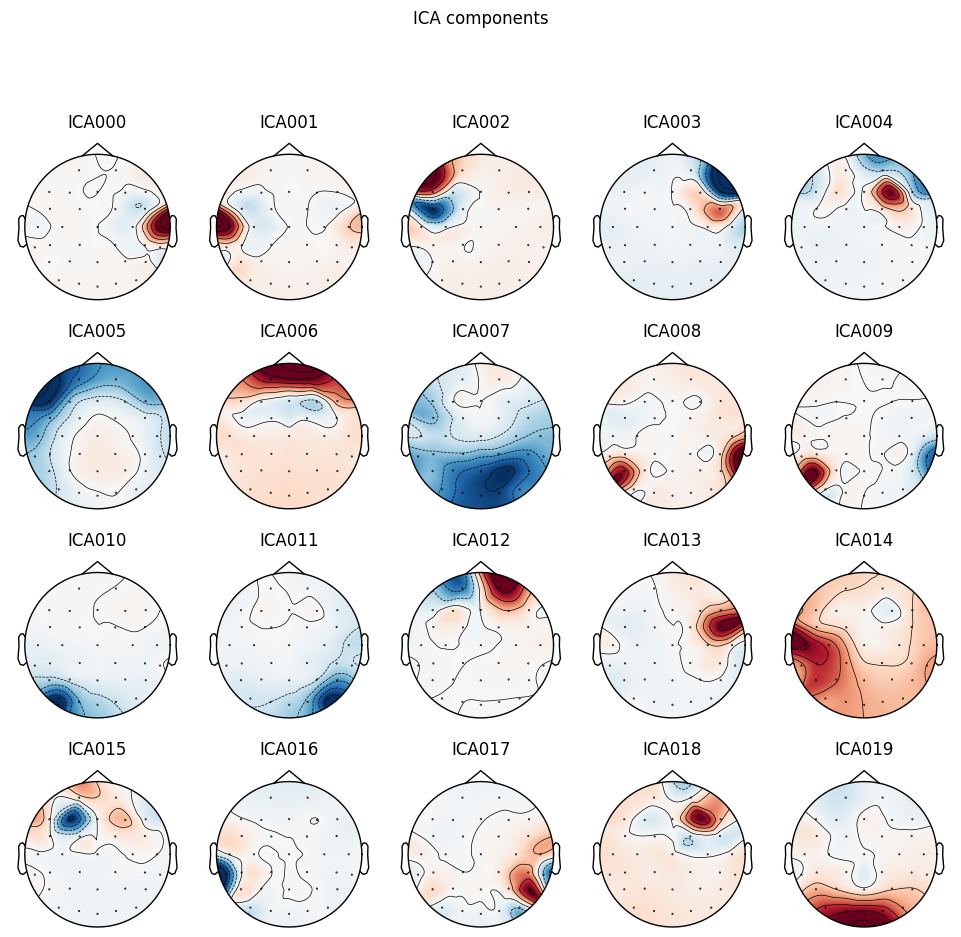

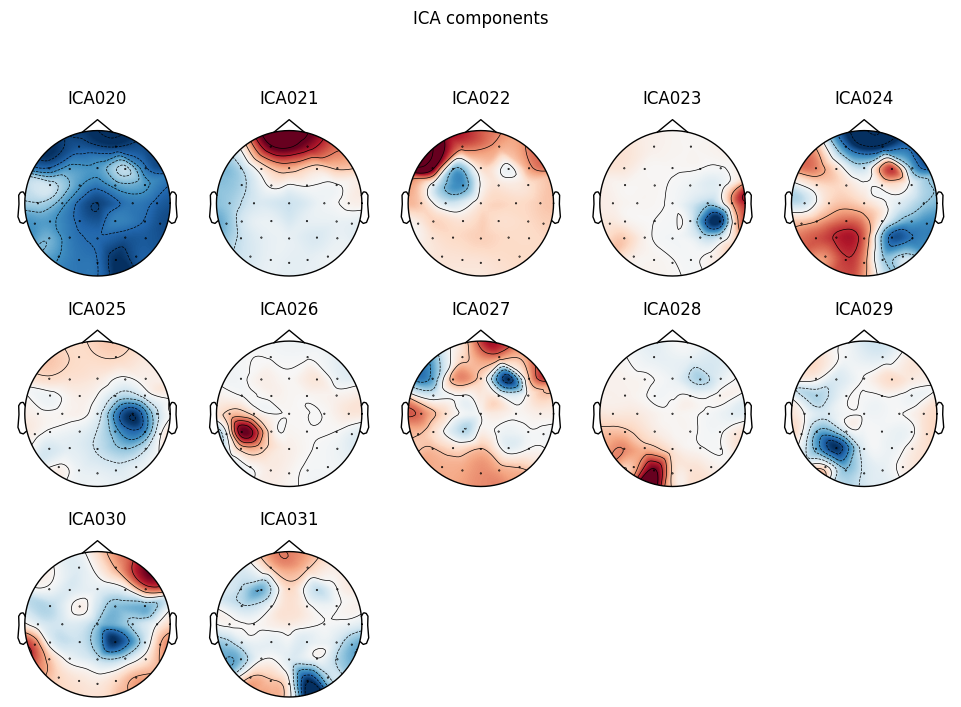

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x731.5 with 12 Axes>]

In [295]:
modelIca.plot_components()

In [296]:
from sklearn.preprocessing import StandardScaler
components = [6, 20, 21]


def prepareAndFilterData(subject: int, series: int, what : Literal["train", "test"]) -> np.ndarray:
    data, keys = loadSubjectSeries(subject, series, what)
    # data = bandFilter(data)
    # ica = icaTransform(data)
    # toExclude = searchIcaTemplates(modelIca, components, ica)
    # data = applyIca(ica, toExclude, data)
    scaler = StandardScaler()
    scaled = scaler.fit_transform(data.get_data().T)
    return scaled


In [297]:
train_set_labels = pd.read_csv("data/train/subj1_series1_events.csv")
train_set_labels.head()
labels = train_set_labels.columns.drop('id')
labelNames = labels.values

In [300]:
labels = train_set_labels.columns.drop('id')
labelNames = labels.values

In [301]:
train_set_signals = pd.read_csv("data/train/subj1_series1_data.csv")
train_set_complete = pd.concat([train_set_signals,train_set_labels], axis=1)
train_set_complete.insert(0, "order", range(0, len(train_set_complete)))

In [302]:
def highlight(indices,ax,color):
    i=0
    while i<len(indices):
        ax.axvspan(indices[i]-0.5, indices[i]+0.5, facecolor=color, edgecolor='none', alpha=.4)
        i+=1      
    

In [303]:
def vizualize_predictions(signals, predictions, expected, labelName, limit=2000): 
    #0-31
    signalIndex = 10
    
    #Relevant only for multilabel predictions, else is always 0
    labelIndex = 0
                
    signals = pd.DataFrame(data=np.array(signals))
    axis = signals[signals.columns[signalIndex]].iloc[0:limit].plot(figsize=(20,4))  
        
    expected = pd.DataFrame(data = expected)    
    predictions = pd.DataFrame(data = np.around(predictions))
    
    expectedCropped = expected.iloc[0:limit,]
    predictionsCropped = predictions.iloc[0:limit,]
    
    highlight(expectedCropped[expectedCropped.iloc[:,labelIndex]==1].index, axis, "red")
    highlight(predictionsCropped[predictionsCropped.iloc[:,labelIndex]==1].index, axis, "black")
    
    red_patch = mpatches.Patch(color='red', label='Expected event')
    black_patch = mpatches.Patch(color='black', label='Predicted event')
    plt.legend(handles=[red_patch, black_patch])

    plt.title(labelName)
    plt.show()

Helper methods for loading data

Features are standartized by removing the mean and scaling to unit variance

Further preprocessing can be done in *prepare_signals* function

In [305]:
import math

def prepareLabels(subject, series, what : Literal["train", "test"]):
    data = pd.read_csv(f"data/{what}/subj{subject}_series{series}_events.csv")
    data = data.drop("id", axis=1)
    return data.to_numpy()
    
def loadDataReady(subject, series, what : Literal["train", "test"] = "train"):    
    return prepareAndFilterData(subject, series, what), prepareLabels(subject, series, what)   


Helper for printing success rates for given predictions and expected values

In [306]:
DOWNSAMPLING = 20
LOOK_BACK = 50
BATCH_SIZE = 512
EPOCHS = 30

In [340]:
def transform(data):
    results = []
    lastOne = None
    lastEnd = -100
    MIN_GAP = 100
    MIN_WIDTH = 0

    for i, dato in enumerate(data):
        if dato == 1 and lastOne == None:
            lastOne = i

        elif dato == 0 and lastOne != None:
            if i-lastEnd < MIN_GAP:
                tmp = results[-1]
                results.pop()
                results.append((tmp[0], i))
            else:
                results.append((lastOne, i))

            lastOne = None
            lastEnd = i

    return results


def printSucc(predictions, expected, dataLabel):
    predictions = np.round(predictions)

    ALLOWED_DEVIATION = 300/DOWNSAMPLING

    tp = transform(predictions)
    te = transform(expected)


    succ = 0

    for p in tp:
        for ie, e in enumerate(te):
            if e[0] - ALLOWED_DEVIATION < p[0] < e[1] + ALLOWED_DEVIATION:
                succ += 1
                te.pop(ie)
                break

    print(f"Successfull {succ}, un {len(tp)-succ + len(te)}")

    return succ/(len(tp)+len(te))


**RECURRENT NEURAL NETWORK**

RNN with LSTM, dropout and activation layers

* Adam optimizer
* Binary crossentropy loss 
* Sigmoid activation layer

Transform 2D dataset to 3D for LSTM layer - add floating window of *look_back* length

In [308]:
def prepareFrames(dataset,labels):
    dataX = np.array([dataset[i:(i+LOOK_BACK)] for i in range(len(dataset)-LOOK_BACK)])
    dataY = np.array(labels[LOOK_BACK//2:-LOOK_BACK//2])
    return dataX, dataY


Tests given rnn model on predicting label or more labels from testing data.

Provides visualisations and success rates.





In [327]:
def evaluate_rnn(subject, model, label, draw):
    #Last (8th) series is used as testing data
    test_signals, test_labels = loadDataReady(subject=subject,series=8)
    
    #Creating sequences for lstm layer
    X_test_signals, X_test_labels = prepareFrames(
        test_signals[::DOWNSAMPLING],
        test_labels[::DOWNSAMPLING],
    )
    #Selecting only desired labels
    X_test_labels = X_test_labels[:,label] 

    #Last few data points that do not fit batch size are omitted 
    croppedSize = math.floor(len(X_test_signals)/BATCH_SIZE)*BATCH_SIZE    

    #Prediction for testing data
    predictions = model.predict(X_test_signals[0:croppedSize], batch_size=BATCH_SIZE)
    expected = X_test_labels[0:croppedSize]
    
    #Selecting only desired labels   
    labelsPredicted = len(predictions[0])
    predictions = predictions[:,0:1]
    
            
    #Success rate printing    
    totalPercent = printSucc(predictions,expected, dataLabel="Testing")
    
    #Vizualization
    if(draw):
        vizualize_predictions(
            test_signals[::DOWNSAMPLING][LOOK_BACK//2:croppedSize+LOOK_BACK//2:],
            predictions,
            expected,
            labelName = labelNames[label],  
            limit = 10000
        )
    
    return totalPercent

Training of a single model for a single or more subjects.

Uses series 1-7 (leaves series 8 for testing)

In [317]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout
from keras.callbacks import EarlyStopping


def train_rnn(subjects, labelToTrain, model): 
    callbacks=[EarlyStopping(monitor="accuracy", verbose=0, patience=10, restore_best_weights=True)]    

    for subject in subjects:
        for j in range(1,8):
            signals, labels = loadDataReady(subject = subject,series = j) 
            #Create sequences
            X_train_signals, X_train_labels = prepareFrames(
                signals[::DOWNSAMPLING],
                labels[::DOWNSAMPLING]
            )        

            X_train_labels = X_train_labels[:,labelToTrain]
            croppedSize = math.floor(len(X_train_signals)/BATCH_SIZE)*BATCH_SIZE    


            #Train model on relevant label (calling fit repeatedly in keras doesnt reset the model)
            model.fit(
                X_train_signals[0:croppedSize],
                X_train_labels[0:croppedSize],
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=True,
                verbose=0,
                callbacks=callbacks
            )            
            
            model.reset_states()
    
    
    print("FITTING DONE")
    return model

In [321]:
def rnn_validation(model, label):
    print(labelNames[label],"label model evaluation")
    
    for subject in range():
        total = evaluate_rnn(subject, model, label)

    print("SUMMARY")
    print("TOTAL :", total)

In [312]:
LABEL = 1

In [313]:
model = Sequential()
model.add(LSTM(50,batch_input_shape=(BATCH_SIZE,LOOK_BACK,32), return_sequences=True, stateful=False, dropout=0.5, activation="softsign")) 
model.add(LSTM(50, return_sequences=False, stateful=False, dropout=0.5, activation="softsign"))     
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [319]:
    #Separate models for training all labels separately
model = train_rnn([1], LABEL, model)

Creating RawArray with float64 data, n_channels=32, n_times=119496
    Range : 0 ... 119495 =      0.000 ...   238.990 secs
Ready.
Creating RawArray with float64 data, n_channels=32, n_times=271954
    Range : 0 ... 271953 =      0.000 ...   543.906 secs
Ready.
Creating RawArray with float64 data, n_channels=32, n_times=217614
    Range : 0 ... 217613 =      0.000 ...   435.226 secs
Ready.
Creating RawArray with float64 data, n_channels=32, n_times=116240
    Range : 0 ... 116239 =      0.000 ...   232.478 secs
Ready.
Creating RawArray with float64 data, n_channels=32, n_times=210644
    Range : 0 ... 210643 =      0.000 ...   421.286 secs
Ready.
Creating RawArray with float64 data, n_channels=32, n_times=249550
    Range : 0 ... 249549 =      0.000 ...   499.098 secs
Ready.
Creating RawArray with float64 data, n_channels=32, n_times=119561
    Range : 0 ... 119560 =      0.000 ...   239.120 secs
Ready.
FITTING DONE


FirstDigitTouch label model evaluation
Creating RawArray with float64 data, n_channels=32, n_times=126733
    Range : 0 ... 126732 =      0.000 ...   253.464 secs
Ready.
12/12 [==============================] - 0s 30ms/step
Successfull 27, un 9


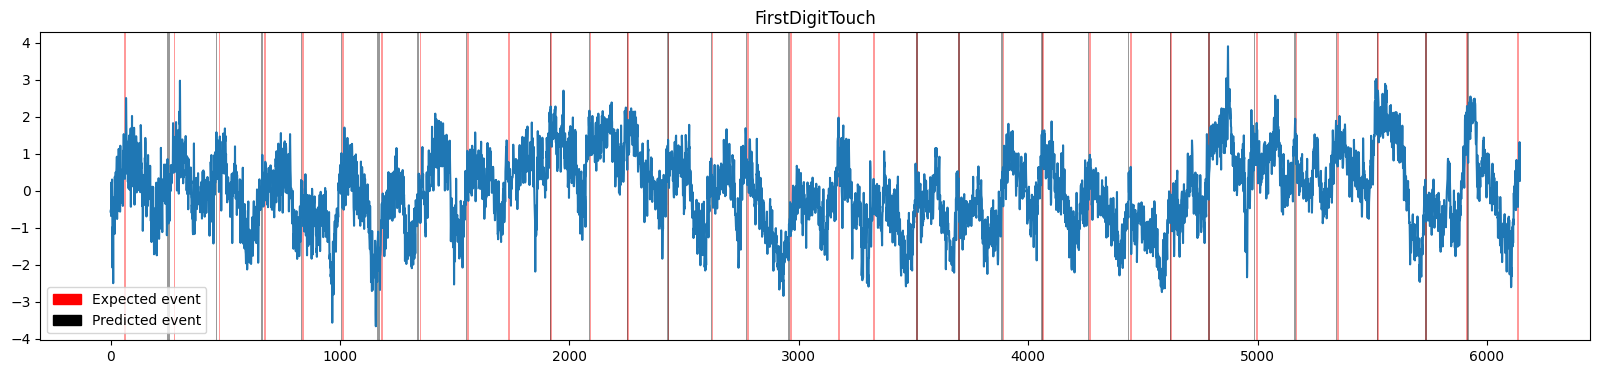

SUMMARY
TOTAL : 0.75


In [341]:
rnn_validation(model, LABEL)